# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Импорт

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

## Исследовательский анализ данных

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим на размер выборки.

In [5]:
print('В выборке', labels.shape[0], 'объект.')

В выборке 7591 объект.


Выборка довольно маленькая для обучения нейросети с нуля - на таком количестве данных сеть будет переобучаться. Но если использовать предобученную сеть, то этой проблемы можно избежать.

Перед анализом проверим, что нет пропусков и данные корректно записаны.

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет, тип данных верный. Построим на распределение возраста.

In [7]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


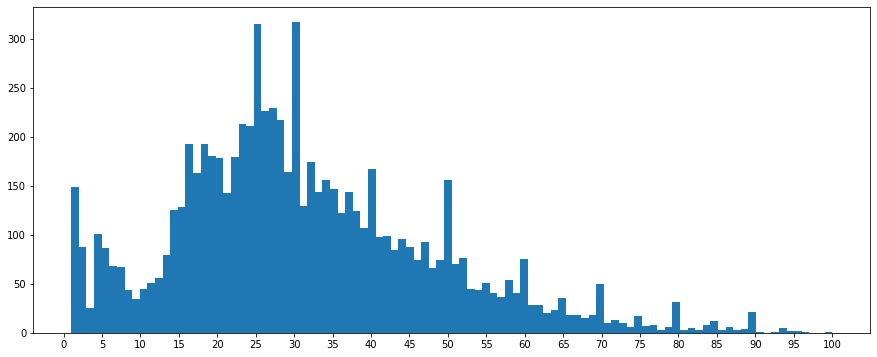

In [8]:
plt.figure(figsize=(15,6))
plt.hist(labels['real_age'], bins=100)
plt.xticks(np.arange(0, 101, 5.0))
plt.show()

На графике мы видим, что лучше всего представлены изображения людей от 15 до 35 лет. Изображения детей представлены неравномерно, очень много изображений с возрастом 1. Возможно стоит проверить, что это корректная цифра. Также много пиков на круглых цифрах - 30, 40, 50 и тд, это связано с тем, что в выборке присутствуют фотографии не только с реальным возрастом, но и с оцененным, видимо в этом случае возраст округляли. Изображений людей пожилого возраста достаточно мало, поэтому скорее всего определять возраст в этой группе модель будет хуже. Лучшим решением этой проблемы будет добавить в датасет больше фотографий, но если это сделать невозможно, можно увеличить количество фотографий с помощью аугментации. В случае фотографий людей не все изменения применимы, например можно использовать отражения по горизонтали, а по вертикали нет.

Посмотрим несколько фотографий из датасета с соответствующими им возрастами.

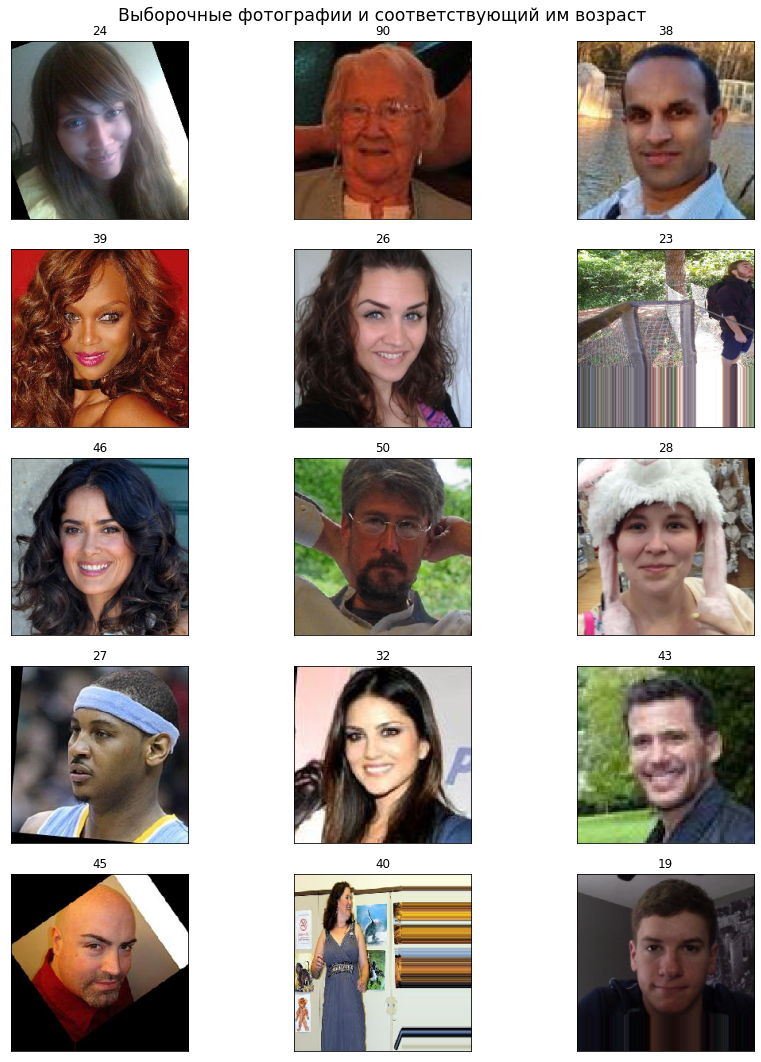

In [17]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(15,15))
plt.suptitle('Выборочные фотографии и соответствующий им возраст', size='xx-large')

for i in range(15):
    fig.add_subplot(5, 3, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

По образцам можно увидеть, что фотографии уже подвергнуты изменениям, есть повороты и растяжения. Также некоторые фотографии цветные, а некоторые нет, то есть имеют разное количество каналов.

Посмотрим на изображения годовалых детей, чтобы проверить, что возраст поставлен корректно.

In [13]:
babies = labels[labels['real_age'] == 1]['file_name'].reset_index(drop=True)

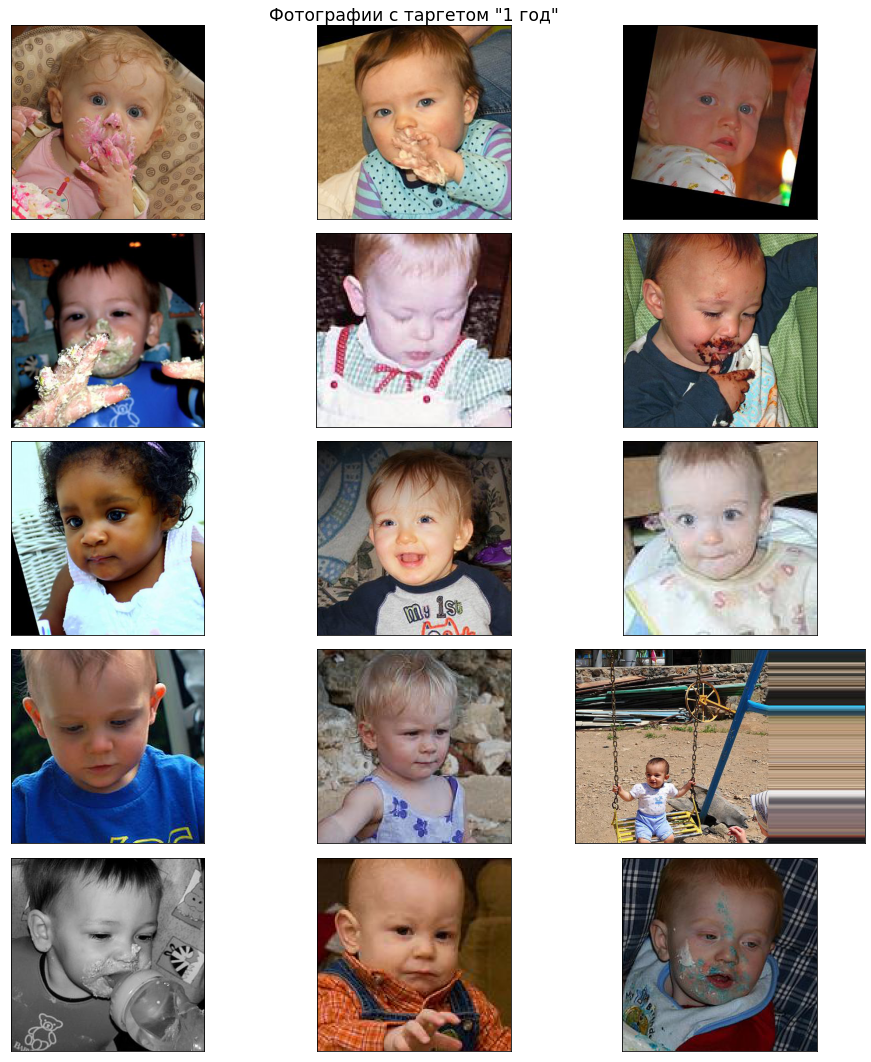

In [16]:
fig = plt.figure(figsize=(15,15))
plt.suptitle('Фотографии с таргетом "1 год"', size='xx-large')
for i in range(15):
    fig.add_subplot(5, 3, i+1)
    img = mpimg.imread('/datasets/faces/final_files/' + str(babies[i]))
    imgplot = plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Мы видим, что на фотографиях не только годовалые дети, но в нашем случае для целей бизнеса достаточно того, что это все очень маленькие дети.

Мы изучили датасет и увидели, что фотографии людей по возрастам распределены неравномерно и некоторых категорий совсем мало, это может представлять сложность при обучении модели.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255)
    
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    
    
    return train_gen_flow


def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25,rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    
    return test_gen_flow


def create_model(input_shape):
    
    optimizer=Adam(lr=0.0005)
    
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=1, activation='relu'))

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, metrics=['mean_absolute_error'])

    return model


def train_model(model, train_data, test_data, batch_size=None, 
                epochs=40,steps_per_epoch=None, 
                validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```

2022-06-11 06:12:54.224031: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-06-11 06:12:54.225710: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-06-11 06:12:56.013090: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-06-11 06:12:56.686618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-11 06:12:56.686704: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-11 06:12:56.686740: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-11 06:12:56.688710: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-11 06:12:56.689117: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-11 06:12:56.691014: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-11 06:12:56.692169: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-11 06:12:56.692243: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-11 06:12:56.696562: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-11 06:12:56.696926: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-06-11 06:12:56.703841: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2099990000 Hz
2022-06-11 06:12:56.704379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x408b770 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-11 06:12:56.704403: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-11 06:12:56.847083: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4057ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-06-11 06:12:56.847134: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-06-11 06:12:56.849928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-06-11 06:12:56.850004: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-11 06:12:56.850021: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-11 06:12:56.850198: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-06-11 06:12:56.850228: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-06-11 06:12:56.850246: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-06-11 06:12:56.850263: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-06-11 06:12:56.850274: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-06-11 06:12:56.855465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-06-11 06:12:56.855551: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-06-11 06:12:57.169635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-06-11 06:12:57.169677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-06-11 06:12:57.169685: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-06-11 06:12:57.174378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 30509 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/40
2022-06-11 06:13:07.889236: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-11 06:13:08.221426: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 45s - loss: 198.4560 - mean_absolute_error: 10.5631 - val_loss: 434.6969 - val_mean_absolute_error: 15.7837
Epoch 2/40
178/178 - 37s - loss: 105.3918 - mean_absolute_error: 7.7827 - val_loss: 334.7827 - val_mean_absolute_error: 13.5678
Epoch 3/40
178/178 - 37s - loss: 65.5617 - mean_absolute_error: 6.1536 - val_loss: 390.5118 - val_mean_absolute_error: 14.8125
Epoch 4/40
178/178 - 37s - loss: 43.5483 - mean_absolute_error: 5.0361 - val_loss: 200.1550 - val_mean_absolute_error: 10.4206
Epoch 5/40
178/178 - 37s - loss: 30.6370 - mean_absolute_error: 4.2659 - val_loss: 139.9904 - val_mean_absolute_error: 9.2908
Epoch 6/40
178/178 - 36s - loss: 22.4628 - mean_absolute_error: 3.5981 - val_loss: 86.4682 - val_mean_absolute_error: 6.9371
Epoch 7/40
178/178 - 36s - loss: 16.6255 - mean_absolute_error: 3.1090 - val_loss: 83.5407 - val_mean_absolute_error: 6.8298
Epoch 8/40
178/178 - 37s - loss: 12.4981 - mean_absolute_error: 2.7145 - val_loss: 75.3485 - val_mean_absolute_error: 6.6233
Epoch 9/40
178/178 - 37s - loss: 8.9454 - mean_absolute_error: 2.2814 - val_loss: 71.8387 - val_mean_absolute_error: 6.3678
Epoch 10/40
178/178 - 36s - loss: 7.8126 - mean_absolute_error: 2.1338 - val_loss: 73.8312 - val_mean_absolute_error: 6.4331
Epoch 11/40
178/178 - 37s - loss: 6.5357 - mean_absolute_error: 1.9444 - val_loss: 71.7691 - val_mean_absolute_error: 6.3914
Epoch 12/40
178/178 - 36s - loss: 6.2475 - mean_absolute_error: 1.8955 - val_loss: 82.7618 - val_mean_absolute_error: 7.0538
Epoch 13/40
178/178 - 37s - loss: 6.3737 - mean_absolute_error: 1.9241 - val_loss: 77.7079 - val_mean_absolute_error: 6.7339
Epoch 14/40
178/178 - 37s - loss: 8.1972 - mean_absolute_error: 2.1735 - val_loss: 78.0934 - val_mean_absolute_error: 6.5949
Epoch 15/40
178/178 - 36s - loss: 11.7820 - mean_absolute_error: 2.5994 - val_loss: 122.1142 - val_mean_absolute_error: 8.3107
Epoch 16/40
178/178 - 37s - loss: 14.8721 - mean_absolute_error: 2.9536 - val_loss: 100.9096 - val_mean_absolute_error: 7.7651
Epoch 17/40
178/178 - 37s - loss: 21.1059 - mean_absolute_error: 3.5066 - val_loss: 108.3874 - val_mean_absolute_error: 7.9104
Epoch 18/40
178/178 - 37s - loss: 52.0485 - mean_absolute_error: 5.2762 - val_loss: 211.2583 - val_mean_absolute_error: 11.5022
Epoch 19/40
178/178 - 37s - loss: 66.4099 - mean_absolute_error: 6.0819 - val_loss: 127.9646 - val_mean_absolute_error: 8.5641
Epoch 20/40
178/178 - 37s - loss: 25.8610 - mean_absolute_error: 3.8576 - val_loss: 110.7220 - val_mean_absolute_error: 7.8146
Epoch 21/40
178/178 - 37s - loss: 11.2940 - mean_absolute_error: 2.5596 - val_loss: 76.2474 - val_mean_absolute_error: 6.6359
Epoch 22/40
178/178 - 36s - loss: 5.1056 - mean_absolute_error: 1.7352 - val_loss: 74.4764 - val_mean_absolute_error: 6.4160
Epoch 23/40
178/178 - 37s - loss: 2.8305 - mean_absolute_error: 1.2796 - val_loss: 70.3365 - val_mean_absolute_error: 6.3658
Epoch 24/40
178/178 - 37s - loss: 1.8634 - mean_absolute_error: 1.0171 - val_loss: 71.8819 - val_mean_absolute_error: 6.4289
Epoch 25/40
178/178 - 37s - loss: 1.5056 - mean_absolute_error: 0.9057 - val_loss: 76.5735 - val_mean_absolute_error: 6.7536
Epoch 26/40
178/178 - 37s - loss: 1.7836 - mean_absolute_error: 0.9918 - val_loss: 72.6929 - val_mean_absolute_error: 6.4871
Epoch 27/40
178/178 - 37s - loss: 2.1187 - mean_absolute_error: 1.0870 - val_loss: 69.9073 - val_mean_absolute_error: 6.3262
Epoch 28/40
178/178 - 37s - loss: 2.7225 - mean_absolute_error: 1.2168 - val_loss: 70.0285 - val_mean_absolute_error: 6.1886
Epoch 29/40
178/178 - 37s - loss: 3.2896 - mean_absolute_error: 1.3382 - val_loss: 74.7081 - val_mean_absolute_error: 6.4520
Epoch 30/40
178/178 - 37s - loss: 4.0475 - mean_absolute_error: 1.4804 - val_loss: 71.4702 - val_mean_absolute_error: 6.2950
Epoch 31/40
178/178 - 37s - loss: 4.5553 - mean_absolute_error: 1.5920 - val_loss: 74.1849 - val_mean_absolute_error: 6.5834
Epoch 32/40
178/178 - 37s - loss: 5.6868 - mean_absolute_error: 1.7786 - val_loss: 78.6232 - val_mean_absolute_error: 6.6197
Epoch 33/40
178/178 - 36s - loss: 6.7481 - mean_absolute_error: 1.9758 - val_loss: 75.2865 - val_mean_absolute_error: 6.6056
Epoch 34/40
178/178 - 37s - loss: 7.1777 - mean_absolute_error: 2.0347 - val_loss: 77.6532 - val_mean_absolute_error: 6.6500
Epoch 35/40
178/178 - 37s - loss: 7.6190 - mean_absolute_error: 2.1045 - val_loss: 76.4400 - val_mean_absolute_error: 6.5168
Epoch 36/40
178/178 - 37s - loss: 6.6722 - mean_absolute_error: 1.9402 - val_loss: 72.5589 - val_mean_absolute_error: 6.4023
Epoch 37/40
178/178 - 36s - loss: 6.2219 - mean_absolute_error: 1.8854 - val_loss: 74.1824 - val_mean_absolute_error: 6.5293
Epoch 38/40
178/178 - 37s - loss: 5.8006 - mean_absolute_error: 1.8175 - val_loss: 84.3512 - val_mean_absolute_error: 7.1308
Epoch 39/40
178/178 - 37s - loss: 5.6385 - mean_absolute_error: 1.7936 - val_loss: 81.4746 - val_mean_absolute_error: 6.8034
Epoch 40/40
178/178 - 37s - loss: 6.0711 - mean_absolute_error: 1.8446 - val_loss: 75.9039 - val_mean_absolute_error: 6.5736
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 75.9039 - mean_absolute_error: 6.5736
Test MAE: 6.5736



```

## Анализ обученной модели

Мы использовали модель ResNet50 предобученную на датасете ImageNet. Последний слой сети был заменен на несколько полносвязных слоев с уменьшающимся количеством выходов. Так как перед нами стояла задача регрессии в последнем слое выход один. В качестве оптимизатора мы использовали Adam с коэффициентом скорости обучения 0,0005, в два раза ниже стандартного чтобы увеличить точность.

Наша модель научилась предсказывать возраст человека по фотографии с ошибкой в 6,5 лет. Изначально мы пытались определить возраст для выполнения двух задач:

* Анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы;
* Контроля добросовестности кассиров при продаже алкоголя.

Однако такая точность подходит только для выполнения первой задачи, так как для продажи алкоголя существует четкая граница 18 лет и возраст +- 6,5 лет в этом случае критичен. 

Также хочется отметить, что мы обучали модель сразу на всех возрастных группах, но разница во внешности детей год от года будет гораздо более сильной чем у взрослых, то есть различить 5 и 10 лет легче, чем 40 и 45. Было бы хорошо дополнительно проверить модель на разных группах, возможно ошибка в группе молодежи будет ниже и это поможет нам четче выполнять вторую задачу.